# Setup
## Imports

In [1]:
import os
from os import environ
from os.path import join
import glob
from tqdm import tqdm

import geopandas as gpd
import pandas as pd
import numpy as np

import rasterio
import xarray as xr
import rioxarray

from pystac_client import Client
import planetary_computer as pc
import stackstac
from dask.diagnostics import ProgressBar

# Functions definition

In [2]:
# Functions
# Functions
def xr_sieve(ds, sieve_thresh: int, connectivity: int = 4):
    """
    Sieving, overloads rasterio function with raster shaped like (1, h, w).
    Inspired from https://sertit-utils.readthedocs.io/en/latest/_modules/sertit/rasters.html#sieve

    .. WARNING::
        Your data is casted by force into :code:`np.uint8`, so be sure that your data is classified.

    Args:
        ds (xarray): xarray DataSet or DaraArray
        sieve_thresh (int): Sieving threshold in pixels
        connectivity (int): Connectivity, either 4 or 8

    Returns:
        (xarray): Sieved xarray
    """
    assert connectivity in [4, 8]

    # Use this trick to make the sieve work
    mask = xr.where(ds.isnull(), 0, 1).data.squeeze().astype('uint8')
    data = ds.data.astype(np.uint8).squeeze()

    # Sieve
    sieved_arr = rasterio.features.sieve(data, size=sieve_thresh, connectivity=connectivity, mask=mask)

    # Set back nodata and expand back dim
    sieved_arr = sieved_arr.astype(ds.dtype)
    if str(ds.dtype).startswith(('float', 'float16', 'float32', 'float64')):
        sieved_arr[np.isnan(np.squeeze(ds.data))] = np.nan

    # Check if we have a shape like (1, x, y) or (x, y)
    if len(ds.shape) > len(sieved_arr.shape):
        sieved_arr = np.expand_dims(sieved_arr, axis=0)

    sieved_ds = ds.copy(data=sieved_arr)

    return sieved_ds

## Parameters

In [10]:
# main path
data_folder = '../data'

# paths
aoi_path = join(data_folder, 'admin', 'adm2.geojson')
modis_path = join(data_folder, 'modis', 'ndvi')

# start / end dates
start_date="2022-01-01"
end_date="2022-12-30"

# Main code
## Define the AOI

In [11]:
aoi_gdf = gpd.read_file(aoi_path)

aoi_utm_crs = aoi_gdf.estimate_utm_crs()
aoi_epsg_geom = aoi_gdf.to_crs(aoi_utm_crs).unary_union
bbox_4326 = aoi_gdf.to_crs(4326).unary_union.bounds # bounding box for search
bbox_epsg = aoi_gdf.to_crs(aoi_utm_crs).unary_union.bounds # to limit the downloaded data

## Search and download satellite images

In [12]:
# open the catalog
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

In [13]:
query = catalog.search(bbox=bbox_4326,
                        collections="modis-13Q1-061",
                        datetime=f'{start_date}/{end_date}')
item_list = query.item_collection()

print(f"Found {len(item_list)} items")

Found 250 items


In [14]:
ds = stackstac.stack(
    item_list,
    assets=["250m_16_days_NDVI"],
    bounds=bbox_epsg,
    resolution=250,
    rescale=False,
    xy_coords='center',
    epsg=aoi_utm_crs.to_epsg(),
    dtype='int64',
    fill_value=-32768
)
with ProgressBar():
    ds.load()

[########################################] | 100% Completed | 63.36 s


In [15]:
# fix the time by parsing the id property
ds['time'] = (
    pd.to_datetime(ds['id'].str[9:13]) 
    + pd.to_timedelta(ds['id'].str[13:16].astype(int) - 1, unit='D')
)
# group by timestamp
ds = ds.groupby("time").max()
ds = ds.rio.write_nodata(-32768).astype('int16')

In [16]:
# export all dates as tiffs
for i in range(len(ds)):
    date = str(ds.isel(time=i)['time'].dt.strftime("%Y-%m-%d").data)
    export_name = date+'_NDVI.tif'
    ds.isel(time=i).rename(date).rio.clip([aoi_epsg_geom]).rio.to_raster(
        join(modis_path, export_name),
        compress="deflate",
        predictor=2
    )

## Perform zonal stats

In [24]:
from rasterstats import zonal_stats

file_list = glob.glob(os.path.join(modis_path, "*.tif"))

# define a model to reproject all the other rasters
df_list = []
for file in tqdm(file_list):
    date = pd.to_datetime(os.path.basename(file)[:10], yearfirst=True)

    # open the raster and extract
    with rioxarray.open_rasterio(file) as da:
        da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
        da = da.astype('float32').where(da != -32768).rio.set_nodata(np.nan) / 10_000
    
        # generate the zonal stats
        stats_dict = zonal_stats(aoi_gdf.to_crs(da.rio.crs), da.data[0], stats=['mean', 'max', 'min', 'std'], affine=da.rio.transform(), nodata=-3000)
        stats_df = pd.DataFrame(stats_dict)
        stats_df['month'] = date
        df_list.append(stats_df)

stats_df = pd.concat(df_list).join(aoi_gdf['district']).reset_index(drop=True)
stats_df = stats_df.sort_values(['month', 'district'])

100%|██████████| 247/247 [03:37<00:00,  1.14it/s]


In [26]:
# export
stats_df.to_csv(join(data_folder, 'indicators', 'ndvi.csv'))

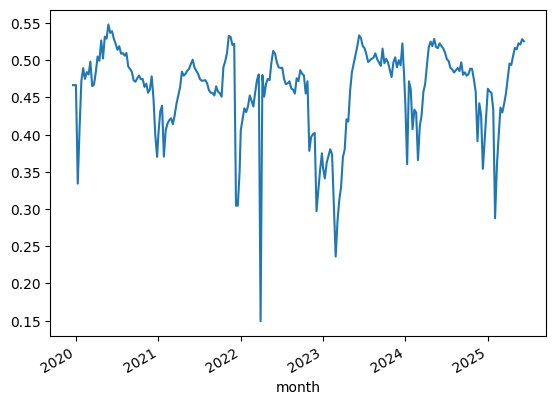

In [28]:
stats_df[stats_df['district']=='Northern Buttes District'].set_index('month')['mean'].plot();

## Generate yearly aggregation

In [ ]:
modis_file_list = glob.glob(join(modis_path, '*.tif'))
years_list = ['2020', '2021', '2022', '2023', '2024', '2025']

df_list = []
for year in tqdm(years_list):
    export_file_tiff = join(data_folder, 'aggregates', f'ndvi_{year}.tif')

    # if os.path.exists(export_file_tiff):
    #     continue

    file_list = sorted([f for f in modis_file_list if os.path.basename(f).startswith(str(year))])
    # if len(file_list) < 12:
    #     print('Only found', len(file_list), 'files for', year, '(expected 12), skipping')
    #     continue

    da_list = []
    # generate a rasters time series for the year
    for file in file_list:
        date = np.datetime64(os.path.basename(file)[:10])
               
        with rioxarray.open_rasterio(file) as da:
            da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
            da = da.astype('float32').where(da != -32768).rio.set_nodata(np.nan) / 10_000
            da_list.append(da)
   
    ds_concat = xr.concat(da_list, dim='time').to_dataset(name='NDVI')
    ds_concat = ds_concat.rio.set_crs(aoi_utm_crs)
    
    # generate cumulated tiff for the year
    ds_concat['NDVI'].mean(dim='time').rio.set_nodata(np.nan).rio.to_raster(export_file_tiff, compress='deflate', predictor=2)

## Calculate crops extent
### Generate cropmask

In [19]:
modis_file_list = glob.glob(join(modis_path, '*.tif'))
years_list = ['2020', '2021', '2022', '2023', '2024', '2025']

df_list = []
for year in tqdm(years_list):
    export_file_tiff = join(data_folder, 'aggregates', f'cropmask_{year}.tif')

    # if os.path.exists(export_file_tiff):
    #     continue
    
    file_list = []
    for modis_file in modis_file_list:
        file_date = np.datetime64(os.path.basename(modis_file)[:10])
        # add all files withing the crop season
        if (file_date >= np.datetime64(f'{int(year)}-04-13') and file_date < np.datetime64(f'{int(year)}-08-21')):
            file_list.append(modis_file)
        file_list = sorted(file_list)

    da_list = []
    # generate a rasters time series for the year
    for file in file_list:
        date = np.datetime64(os.path.basename(file)[:10]).astype('datetime64[ns]')
               
        with rioxarray.open_rasterio(file) as da:
            da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
            da = da.astype('float32').where(da != -32768).rio.set_nodata(np.nan) / 10_000
            da_list.append(da)
   
    ds_concat = xr.concat(da_list, dim='time').to_dataset(name='NDVI')
    ds_concat = ds_concat.rio.set_crs(aoi_utm_crs)

    # pixels above threshold during growing season
    binary_ds = (((ds_concat['NDVI'] >= 0.5 ).sum(dim='time') >= 4)).astype('uint8')

    # apply a sieve
    binary_ds = xr_sieve(binary_ds, 3)
    
    # generate cumulated tiff for the year
    binary_ds.rio.to_raster(export_file_tiff, compress='deflate', predictor=2)

100%|██████████| 6/6 [00:22<00:00,  3.76s/it]


### Calculate stats on cropmask

In [21]:
from rasterstats import zonal_stats

file_list = sorted(glob.glob(os.path.join(data_folder, 'aggregates', "cropmask_*.tif")))

# define a model to reproject all the other rasters
df_list = []
for file in tqdm(file_list):
    date = pd.to_datetime(os.path.basename(file)[9:13]+'-01-01', yearfirst=True)

    # open the raster and extract
    with rioxarray.open_rasterio(file) as da:
        da = da.squeeze(dim='band').drop_vars('band').expand_dims(time=[date])
        da = da.astype('float32').where(da != 0).rio.set_nodata(np.nan)
        res = max(da.rio.resolution()) # calculate spatial resolution
        da = da*res**2/10_000 # convert to ha
    
        # generate the zonal stats
        stats_dict = zonal_stats(aoi_gdf.to_crs(da.rio.crs), da.data[0], stats=['sum'], affine=da.rio.transform(), nodata=np.nan)
        stats_df = pd.DataFrame(stats_dict)
        stats_df['month'] = date
        df_list.append(stats_df)

stats_df = pd.concat(df_list).join(aoi_gdf['district']).reset_index(drop=True)
stats_df = stats_df.sort_values(['month', 'district'])

100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


In [22]:
# export
stats_df.to_csv(join(data_folder, 'indicators', 'cropmask.csv'))